In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

from datetime import datetime
from datetime import timedelta

import time
from os import listdir
from os.path import isfile, join
import re

plt.rcParams.update(plt.rcParamsDefault)

In [6]:
!pip freeze > requirements.txt

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Non-Pharmaceutical Interventions in Canada

Here we show comparisons of descriptive statistics for each regional and subregional-level dataset across Canada. Download individual region CSVs from the Google Sheet and place them in `./data/`. 

Stats Canada data on population size by province available from: 

Statistics Canada. Table 17-10-0009-01 Population estimates, quarterly"
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901
DOI: https://doi.org/10.25318/1710000901-eng


In [7]:
cutoff_date = datetime(2020, 7, 7)

In [8]:
stats_columns=[
    'file',
    'region',
    'subregion', 
    'rows',
    'columns',
    'start_date.min', 
    'start_date.max', 
    'end_date.min', 
    'end_date.max', 
    'end_date.count / count', 
    'reviewer.unique', 
    'intervention_summary.unique', 
    'intervention_category.unique',
    'target_population_category.unique',
    'target_population_category (% not "General")',
    'enforcement_category.unique',
    'oxford_government_response_category.notna',
    'oxford_government_response_category.unique',
    'oxford_fiscal_measure_cad.sum',
    'source_url.unique'
]

columns=[
    'start_date',
    'end_date',
    'reviewer',
    'country',
    'region',
    'subregion',
    'intervention_summary',
    'intervention_category',
    'target_population_category',
    'enforcement_category',
    'oxford_government_response_category',
    'oxford_closure_code',
    'oxford_public_info_code',
    'oxford_travel_code',
    'oxford_geographic_target_code',
    'oxford_fiscal_measure_cad',
    'oxford_monetary_measure',
    'oxford_testing_code',
    'oxford_tracing_code',
    'oxford_restriction_code',
    'oxford_income_amount',
    'oxford_income_target',
    'oxford_debt_relief_code',
    'source_url',
    'source_organization',
    'source_organization_2',
    'source_category',
    'source_title',
    'source_full_text',
    'note',
    'end_source_url',
    'end_source_organization',
    'end_source_organization_2',
    'end_source_category',
    'end_source_title',
    'end_source_full_text'
]

In [9]:
population_df = pd.read_csv('data/statscan-population-q.csv', thousands=',')
population_df[['Geography', 'Q1 2020']]
population_df['region'] = population_df['Geography']
population_df['population_q1_2020'] = pd.to_numeric(population_df['Q1 2020'])
population_df = population_df[['region', 'population_q1_2020']]
population_df

,region,population_q1_2020
0,Canada,37894799
1,Newfoundland and Labrador,521365
2,Prince Edward Island,158158
3,Nova Scotia,977457
4,New Brunswick,779993
5,Quebec,8537674
6,Ontario,14711827
7,Manitoba,1377517
8,Saskatchewan,1181666
9,Alberta,4413146


In [10]:
full_df = pd.read_csv('SCHEMA UPDATE - Collecting NPIs Effects - FULL.csv', error_bad_lines=False)
full_df['start_date'] = pd.to_datetime(full_df['start_date'], format='%m/%d/%Y', errors='coerce')
full_df['end_date'] = pd.to_datetime(full_df['end_date'], format='%m/%d/%Y', errors='coerce')
full_df['oxford_fiscal_measure_cad'] = full_df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)
full_df['end_source_full_text'] = full_df['end_source_full_text'].astype(str)



In [11]:
full_df = full_df[full_df['start_date'] <= cutoff_date]
full_df = full_df[~full_df['start_date'].isna()]

provinces_df = full_df[full_df['subregion'].isna() & full_df['region'].notna() & (full_df['region'] != "All")]

federal_df = full_df[full_df['subregion'].isna() & (full_df['region'].isna() | (full_df['region'] == "All"))]

In [12]:
full_df.shape

(4140, 35)

In [13]:
provinces_df.shape

(2133, 35)

In [14]:
federal_df.shape

(158, 35)

In [15]:
object_columns = full_df.dtypes[full_df.dtypes == 'object'].index.values

# Cleans up columns

full_df[object_columns] = full_df[object_columns].replace('\n',' ', regex=True)
full_df[object_columns] = full_df[object_columns].replace('\r',' ', regex=True)
full_df.shape

(4140, 35)

In [16]:
full_df.drop(columns=['reviewer']).to_csv('npi_canada.csv')
#provinces_df.drop(columns=['reviewer']).to_csv('npi_by_province.csv')
#federal_df.drop(columns=['reviewer']).to_csv('npi_federal.csv')

In [17]:
check = pd.read_csv('npi_canada.csv')

# Descriptive Statistics for Paper

In [18]:
print("Number of interventions recorded: ", full_df.shape[0])

Number of interventions recorded:  4140


In [19]:
print("Number of oxford interventions recorded: ", full_df['oxford_government_response_category'].count())

Number of oxford interventions recorded:  1824


In [20]:
print("Number of unique source urls: ", len(full_df['source_url'].unique()))

Number of unique source urls:  2630


In [21]:
print("Number of unique primary source organizations: ", len(full_df['source_organization'].unique()))

Number of unique primary source organizations:  277


In [22]:
oxford_ratio = full_df['oxford_government_response_category'].count() / full_df['intervention_category'].count()
print("% of interventions with oxford classifications: ", oxford_ratio)



% of interventions with oxford classifications:  0.4422890397672163


In [23]:
full_df['oxford_government_response_category'].value_counts().sort_index()

C1 School Closing                            59
C2 Workplace Closures                       289
C3 Cancel public events                     131
C4 Public Gathering Restrictions             96
C5 Close public transport                    10
C6 Stay at Home                               7
C7 Restrictions on internal movements       200
C8 International Travel Controls             82
E1 Income Support                            44
E2 Debt / Contract Relief for Households     91
E3 Fiscal measures                          305
E4 Support for Other Countries                4
H1 Public Info Campaigns                    311
H2 Testing policy                            83
H3 Contact tracing                            8
H4 Emergency investment in health care       91
H5 Investment in vaccines                    13
Name: oxford_government_response_category, dtype: int64

In [24]:
assert full_df['oxford_government_response_category'].nunique() == 17

In [25]:
full_df['end_date'].count()

424

In [26]:
full_df['country'].unique()

array(['Canada', nan], dtype=object)

In [27]:
full_df['region'].unique()

array(['Northwest Territories', 'Alberta', 'All', 'Quebec',
       'British Columbia', 'Ontario', 'Manitoba', 'New Brunswick',
       'Nova Scotia', 'Newfoundland and Labrador', 'Yukon',
       'Saskatchewan', nan, 'Atlantic Canada', 'Manitoba ', 'Nunavut',
       'All except Greater Montreal', 'Prince Edward Island'],
      dtype=object)

In [28]:
full_df['subregion'].unique()

array([nan, 'Calgary', 'Vancouver', 'Kelowna', 'Winnipeg', 'Montreal',
       'Ottawa', 'Gatineau', 'Victoria', 'Edmonton', 'Toronto', 'Regina',
       'London', 'Quebec City', "St. John's", 'Halifax', 'Muskoka',
       'Kingston', 'Kitchener-Waterloo', 'Hamilton', 'Saskatoon',
       'Windsor', 'Oshawa', 'All except Greater Montreal',
       'Greater Montreal', 'Laval', 'Niagara'], dtype=object)

In [29]:
print("Number of regions: ", full_df['country'].nunique())
print("Number of regions: ", full_df['region'].nunique())
print("Number of subregions: ", full_df['subregion'].nunique())

assert full_df['country']Re.nunique() == 1 # canada
#assert full_df['region'].nunique() == 15 # 13 provinces + nan + All
#assert full_df['subregion'].nunique() == 21

Number of regions:  1
Number of regions:  17
Number of subregions:  26


# NPIs before Key Dates

In [30]:
full_11_df = full_df[full_df['start_date'] < '2020-03-11']
print("Number of interventions recorded before may 11: ", full_11_df.shape[0])
print("Number of interventions recorded before may 11 (%): ", full_11_df.shape[0] / full_df.shape[0])


Number of interventions recorded before may 11:  135
Number of interventions recorded before may 11 (%):  0.03260869565217391


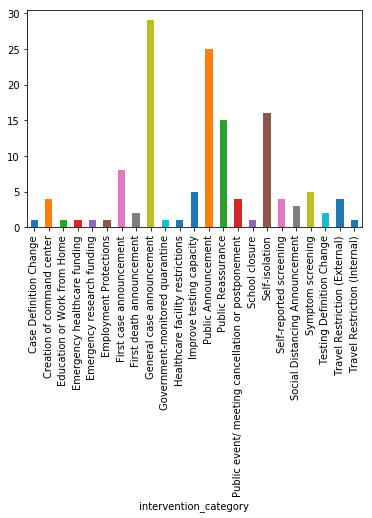

In [31]:
full_11_df.groupby(by='intervention_category')['start_date'].count().plot.bar()

In [32]:
full_1_df = full_df[full_df['start_date'] < '2020-01-25'] # first case
print("Number of interventions recorded before Jan 25: ", full_1_df.shape[0])
print("Number of interventions recorded before Jan 25 (%): ", full_1_df.shape[0] / full_df.shape[0])


Number of interventions recorded before Jan 25:  9
Number of interventions recorded before Jan 25 (%):  0.002173913043478261


In [33]:
9 / full_df.shape[0]

0.002173913043478261

In [34]:
full_1_df['intervention_category'].unique()

array(['Public Announcement', 'Public Reassurance', 'Symptom screening',
       'Improve testing capacity', 'Self-reported screening'],
      dtype=object)

## NPI: Enforcement Categories


In [35]:
len(full_df['enforcement_category'].unique())

7

In [36]:
full_df.groupby(by='enforcement_category').count().max(axis=1).sort_values()

enforcement_category
Not Applicable         1
Arrest                 8
Legal Action          50
Fines                105
Refusal of Entry     193
Not Applicable      3698
dtype: int64

Text(0.5,0,'count')

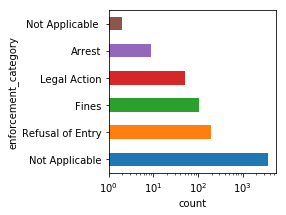

In [37]:
full_df.groupby(by="enforcement_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(3,3))
plt.xlabel('count')

## Target Population Categories

In [38]:
len(full_df['target_population_category'].unique())

19

Text(0.5,0,'count')

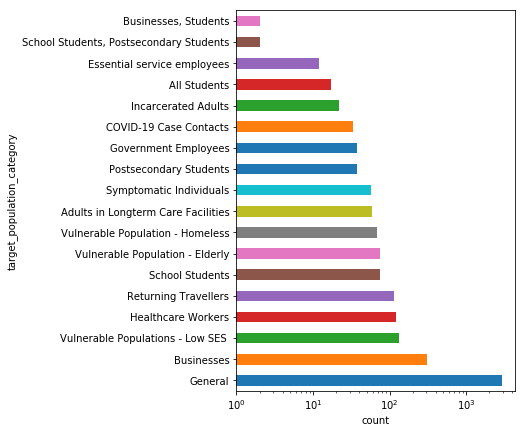

In [39]:
full_df.groupby(by="target_population_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(5,7))
plt.xlabel('count')

## NPI: Intervention Categories

In [40]:
n_interventions_unique = len(full_df['intervention_category'].unique())
print('Unique interventions: ', n_interventions_unique)
assert n_interventions_unique == 61

Unique interventions:  62


AssertionError: 

Lets show examples of the top 15 interventions by count

In [41]:
intervention_counts = pd.DataFrame(full_df.groupby(by='intervention_category').count().max(axis=1))

In [42]:
pd.set_option('display.max_colwidth', -1)

examples = pd.DataFrame(full_df.groupby(by='intervention_category').apply(lambda x: x.sample(1, random_state=3)['intervention_summary'].values[0]))

intervention_counts.merge(examples, left_index=True, right_index=True).sort_values(by='0_x', ascending=False)[0:17]



,0_x,0_y
intervention_category,,
Public Announcement,756,Public Health Services identifies 31 Congregate Living Settings where Section 22 Orders under the Health Promotion and Protect Act (HPPA) have been issued
General case announcement,538,12 long term care homes with COVID outbreaks in Waterloo
Emergency economic funding,290,"A $150 M emergency relief program, involves small business operating capital loans of up to $50 000.These loans are to be managed by regional county municipalities or municipalities. For Gatineau, those loans will be managed by ID Gatineau."
Emergency social services funding,189,Financial support from Telus in the form of grants to local grassroots charities
Social Distancing Announcement,185,Patrolling by police officer brigades to reincorce physical distancing
Administrative flexibility,141,Postponement of telecom auction for 3500 MHz spectrum
Recreational / Entertainment Facility Closure or Restriction,141,Closure of Espace Pour La Vie museums
Public event/ meeting cancellation or postponement,124,Annual Canada Day Cellebration for Seniors cancelled
Non-essential workplace closure,103,Personal service setting closed


In [43]:
full_df[full_df['oxford_government_response_category'].isna()].groupby(by='intervention_category').count().max(axis=1).sort_values(ascending=False)


intervention_category
Public Announcement                                             595
General case announcement                                       503
Administrative flexibility                                      115
Emergency social services funding                               78 
Declaration of emergency (or similar)                           77 
Recreational / Entertainment Facility Closure or Restriction    77 
Social Distancing Announcement                                  76 
Healthcare facility restrictions                                64 
Public Reassurance                                              49 
Public park restriction or closure                              49 
Health workforce task-shifting                                  47 
Social Service provider restrictions                            38 
Face Mask Recommendation                                        35 
Improve testing capacity                                        35 
Education or Work from Hom

Text(0.5,0,'count')

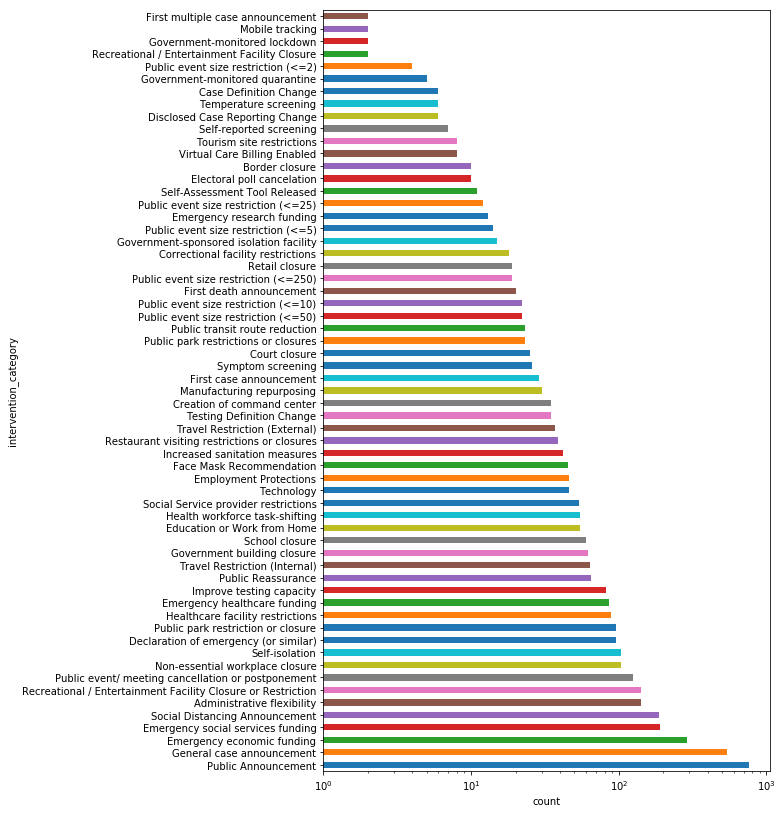

In [44]:

full_df.groupby(by="intervention_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(8,14))
plt.xlabel('count')


# Sources

Looking at unique source urls, organizations, and source types

In [45]:
a = full_df['source_organization'].unique()
a.shape

(277,)

In [46]:
b = full_df['source_organization_2'].unique()

In [47]:
all_sources = list(set(a) | set(b))
len(all_sources)

403

## NPI: Fiscal Measures

Show investments by province or subregion

In [48]:
#fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='05-20-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')
provinces_fiscal = pd.DataFrame(dates)

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['cumulative'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    all_dates_df.set_index('start_date')
    all_dates_df = all_dates_df.groupby(by='start_date').sum()

    provinces_fiscal[g_name] = all_dates_df['cumulative']

#plt.yscale('log')
#plt.title('')
#plt.ylabel('Fiscal Interventions ($)')
#plt.xlabel('Date')

#provinces_fiscal

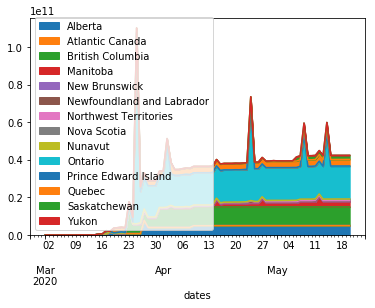

In [49]:
print("WARNING: Not Correct Yet")
provinces_fiscal.drop(['dates'], axis=1).plot.area()

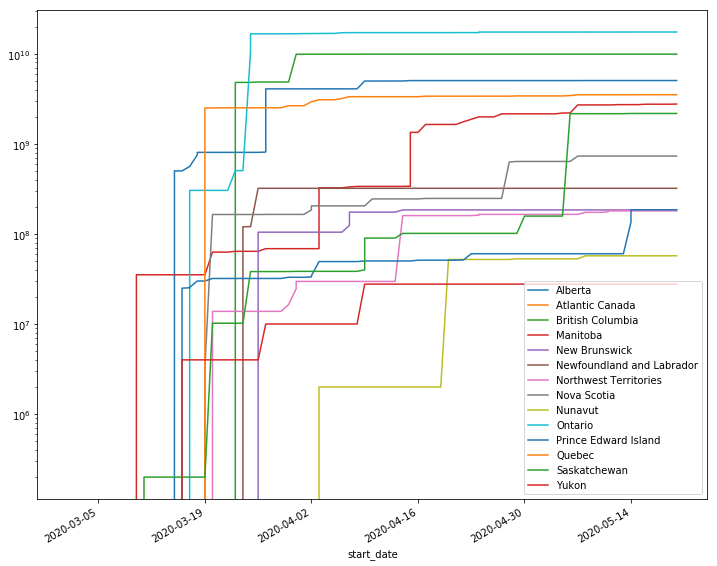

In [50]:
fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='05-20-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['oxford_fiscal_measure_cad_cumsum'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    #print(all_dates_df)
    all_dates_df.plot(x='start_date', y='oxford_fiscal_measure_cad_cumsum', label=g_name, ax=ax)

plt.yscale('log')

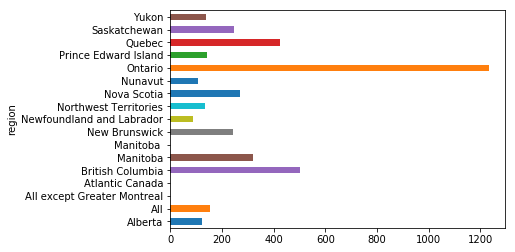

In [51]:
full_df.groupby(by=['region']).count().max(axis=1).plot.barh()

In [52]:
full_df.groupby(by=['region'])['start_date'].quantile(0.5).sort_values()

region
British Columbia              2020-03-25
Newfoundland and Labrador     2020-03-26
Nunavut                       2020-03-27
Saskatchewan                  2020-03-31
Quebec                        2020-04-02
Alberta                       2020-04-03
Northwest Territories         2020-04-06
New Brunswick                 2020-04-09
Ontario                       2020-04-09
Prince Edward Island          2020-04-09
Nova Scotia                   2020-04-17
Manitoba                      2020-04-24
Yukon                         2020-04-24
Manitoba                      2020-04-30
All                           2020-05-03
All except Greater Montreal   2020-06-01
Atlantic Canada               2020-06-23
Name: start_date, dtype: datetime64[ns]

# Temporal Distribution of Events

In [53]:
full_df['start_date'].quantile(0.5)

Timestamp('2020-04-07 00:00:00')

In [54]:
provinces_df['start_date'].quantile(0.5)

Timestamp('2020-04-07 00:00:00')

In [55]:
full_df['start_date'].quantile(0.5)

Timestamp('2020-04-07 00:00:00')

In [56]:
earliest_dates = provinces_df.groupby(by='region')['start_date'].min()
earliest_dates

region
Alberta                       2020-03-05
All except Greater Montreal   2020-06-01
Atlantic Canada               2020-06-23
British Columbia              2020-01-20
Manitoba                      2020-01-28
New Brunswick                 2020-03-01
Newfoundland and Labrador     2020-03-06
Northwest Territories         2020-03-10
Nova Scotia                   2020-02-28
Nunavut                       2020-01-07
Ontario                       2020-01-22
Prince Edward Island          2020-02-28
Quebec                        2020-03-11
Saskatchewan                  2020-02-13
Yukon                         2020-03-07
Name: start_date, dtype: datetime64[ns]

In [57]:
assert earliest_dates.min() > datetime(2020, 1, 1)

In [58]:
latest_dates = provinces_df.groupby(by='region')['start_date'].max()
latest_dates

region
Alberta                       2020-06-05
All except Greater Montreal   2020-06-01
Atlantic Canada               2020-06-23
British Columbia              2020-05-15
Manitoba                      2020-07-07
New Brunswick                 2020-06-01
Newfoundland and Labrador     2020-04-26
Northwest Territories         2020-06-29
Nova Scotia                   2020-07-07
Nunavut                       2020-07-06
Ontario                       2020-07-06
Prince Edward Island          2020-07-05
Quebec                        2020-06-26
Saskatchewan                  2020-06-15
Yukon                         2020-07-06
Name: start_date, dtype: datetime64[ns]

In [59]:
assert latest_dates.min() <= cutoff_date

In [60]:
latest_dates[latest_dates < cutoff_date - timedelta(7)]

region
Alberta                       2020-06-05
All except Greater Montreal   2020-06-01
Atlantic Canada               2020-06-23
British Columbia              2020-05-15
New Brunswick                 2020-06-01
Newfoundland and Labrador     2020-04-26
Northwest Territories         2020-06-29
Quebec                        2020-06-26
Saskatchewan                  2020-06-15
Name: start_date, dtype: datetime64[ns]

In [61]:
cma_earliest_dates = full_df.dropna(subset=['subregion']).groupby(by='subregion')['start_date'].min()
cma_earliest_dates

subregion
All except Greater Montreal   2020-05-04
Calgary                       2020-03-10
Edmonton                      2020-03-14
Gatineau                      2020-03-13
Greater Montreal              2020-05-14
Halifax                       2020-03-16
Hamilton                      2020-03-11
Kelowna                       2020-03-07
Kingston                      2020-05-08
Kitchener-Waterloo            2020-03-05
Laval                         2020-05-21
London                        2020-03-12
Montreal                      2020-02-28
Muskoka                       2020-05-08
Niagara                       2020-03-13
Oshawa                        2020-03-13
Ottawa                        2020-03-11
Quebec City                   2020-03-13
Regina                        2020-03-16
Saskatoon                     2020-03-12
St. John's                    2020-03-13
Toronto                       2020-01-07
Vancouver                     2020-03-09
Victoria                      2020-03-11
Windso

In [62]:
assert cma_earliest_dates.min() > datetime(2020, 1, 1)

In [63]:
cma_latest_dates = full_df.dropna(subset=['subregion']).groupby(by='subregion')['start_date'].max()
cma_latest_dates

subregion
All except Greater Montreal   2020-05-04
Calgary                       2020-06-03
Edmonton                      2020-06-15
Gatineau                      2020-04-30
Greater Montreal              2020-06-01
Halifax                       2020-07-06
Hamilton                      2020-06-22
Kelowna                       2020-06-13
Kingston                      2020-05-08
Kitchener-Waterloo            2020-07-06
Laval                         2020-05-21
London                        2020-07-06
Montreal                      2020-06-26
Muskoka                       2020-05-08
Niagara                       2020-06-30
Oshawa                        2020-06-05
Ottawa                        2020-07-06
Quebec City                   2020-05-19
Regina                        2020-07-01
Saskatoon                     2020-06-08
St. John's                    2020-07-06
Toronto                       2020-07-07
Vancouver                     2020-06-26
Victoria                      2020-06-19
Windso

In [64]:
assert cma_latest_dates.min() <= cutoff_date

In [65]:
cma_latest_dates[cma_latest_dates < cutoff_date - timedelta(7)]

subregion
All except Greater Montreal   2020-05-04
Calgary                       2020-06-03
Edmonton                      2020-06-15
Gatineau                      2020-04-30
Greater Montreal              2020-06-01
Hamilton                      2020-06-22
Kelowna                       2020-06-13
Kingston                      2020-05-08
Laval                         2020-05-21
Montreal                      2020-06-26
Muskoka                       2020-05-08
Oshawa                        2020-06-05
Quebec City                   2020-05-19
Saskatoon                     2020-06-08
Vancouver                     2020-06-26
Victoria                      2020-06-19
Winnipeg                      2020-05-15
Name: start_date, dtype: datetime64[ns]

In [66]:
full_df.groupby(by=['start_date'])['intervention_category'].count()

start_date
2020-01-07    2 
2020-01-20    1 
2020-01-21    2 
2020-01-22    1 
2020-01-23    2 
2020-01-24    1 
2020-01-25    5 
2020-01-26    2 
2020-01-27    1 
2020-01-28    6 
2020-01-29    1 
2020-01-30    1 
2020-01-31    4 
2020-02-02    2 
2020-02-03    2 
2020-02-04    2 
2020-02-06    1 
2020-02-07    4 
2020-02-09    1 
2020-02-10    1 
2020-02-12    1 
2020-02-13    2 
2020-02-14    1 
2020-02-15    1 
2020-02-19    1 
2020-02-20    2 
2020-02-23    1 
2020-02-24    5 
2020-02-26    1 
2020-02-27    2 
             .. 
2020-06-08    18
2020-06-09    21
2020-06-10    22
2020-06-11    15
2020-06-12    30
2020-06-13    10
2020-06-14    4 
2020-06-15    29
2020-06-16    11
2020-06-17    15
2020-06-18    23
2020-06-19    23
2020-06-20    5 
2020-06-21    3 
2020-06-22    19
2020-06-23    20
2020-06-24    19
2020-06-25    9 
2020-06-26    13
2020-06-27    6 
2020-06-28    2 
2020-06-29    10
2020-06-30    15
2020-07-01    15
2020-07-02    16
2020-07-03    9 
2020-07-04    3 
202

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30'],
              dtype='datetime64[ns]', freq='M')


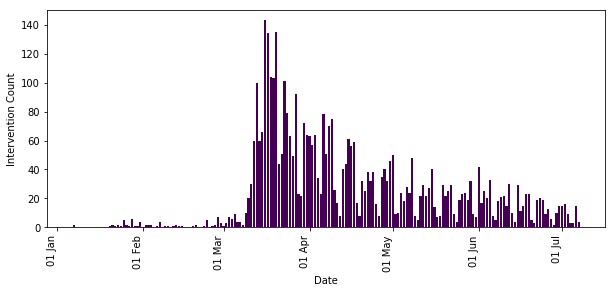

In [67]:
import matplotlib.dates as mdates
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,4))

xticks = pd.date_range(start='01-01-2020', end=cutoff_date, freq='M')
#subset = full_df[full_df['start_date'] < pd.to_datetime('04-01-2020')]
ts = full_df.groupby(by=['start_date'])['intervention_category'].count()

cmap = mpl.cm.get_cmap('viridis')
plt.bar(ts.index, ts.values, color=cmap(0))

plt.xlabel('Date')
plt.ylabel('Intervention Count')

locator = mdates.MonthLocator()
locator.MAXTICKS = 10000

plt.gca().xaxis.set_major_locator(locator)
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)
plt.xticks(rotation=90, ha='right')

print(xticks)

DatetimeIndex(['2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30'],
              dtype='datetime64[ns]', freq='M')


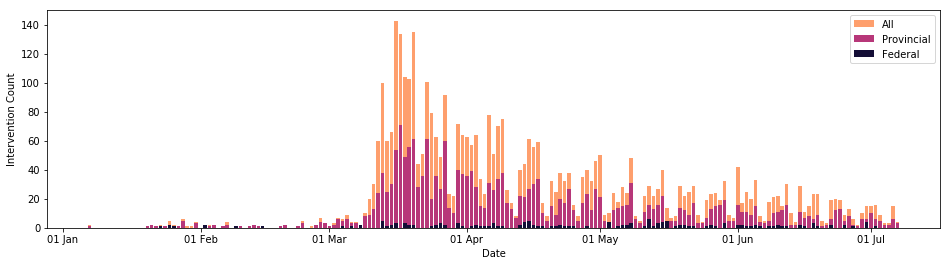

In [69]:
import matplotlib.dates as mdates
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(16, 4))

xticks = pd.date_range(start='12-01-2019', end=cutoff_date, freq='M')
#subset = full_df[full_df['start_date'] < pd.to_datetime('04-01-2020')]


cmap = mpl.cm.get_cmap('magma')


ts = full_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.8), label='All')

ts = provinces_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.5), label='Provincial')

ts = federal_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.1), label='Federal')



plt.xlabel('Date')
plt.ylabel('Intervention Count')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)
print(xticks)
plt.legend()

#ts = full_df.subtract(provinces_df).groupby(by=['start_date'])['intervention_category'].count()
#cmap = mpl.cm.get_cmap('viridis')
#plt.bar(ts.index, ts.values, color=cmap(.5), alpha=0.4)
plt.savefig('doc/img/fig2.png', dpi=300)

# Geographical Distribution of Interventions

In [70]:
names = full_df['region']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

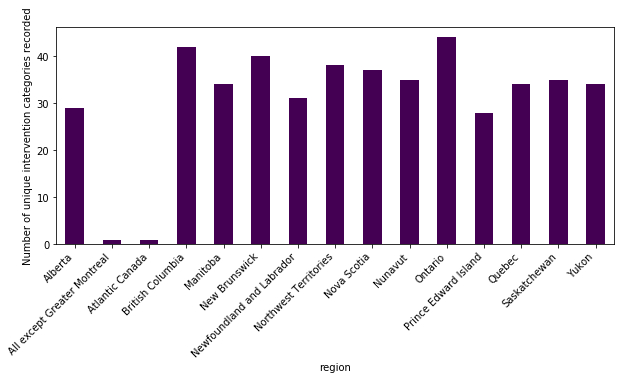

In [71]:
import matplotlib.ticker as ticker
provinces_df.dropna(subset=['region']).groupby(by=['region'])['intervention_category'].nunique().plot.bar(figsize=(10,4), cmap='viridis')
plt.ylabel('Number of unique intervention categories recorded')

#@ticker.FuncFormatter
#def major_formatter(x, pos):
#    return str(x).replace('(', '').replace('(', '')
#plt.gca().xaxis.set_major_formatter(major_formatter)
plt.xticks(rotation=45, ha='right')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

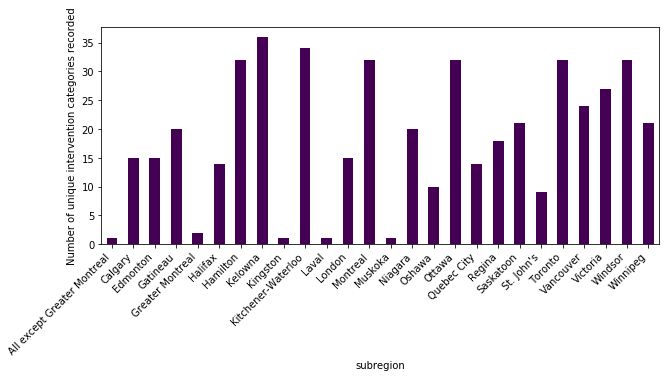

In [72]:
import matplotlib.ticker as ticker
subregions = full_df.dropna(subset=['subregion']).groupby(by=['subregion'])['intervention_category'].nunique()

subregions.plot.bar(figsize=(10,4), cmap='viridis')
plt.ylabel('Number of unique intervention categories recorded')

#@ticker.FuncFormatter
#def major_formatter(x, pos):
#    return str(x).replace('(', '').replace('(', '')
#plt.gca().xaxis.set_major_formatter(major_formatter)
plt.xticks(rotation=45, ha='right')


Text(0.5,0,'Number of unique Oxford interventions recorded')

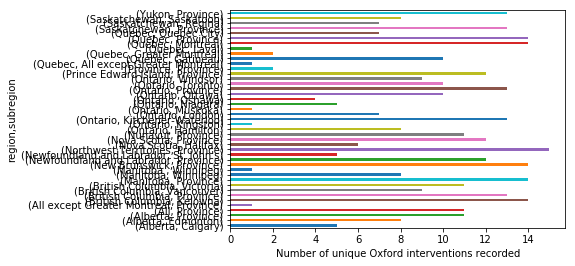

In [67]:
full_df.fillna('Province').groupby(by=['region', 'subregion'])['oxford_government_response_category'].nunique().plot.barh()
plt.xlabel('Number of unique Oxford interventions recorded')


Text(0,0.5,'Unique Intervention Categories Recorded')

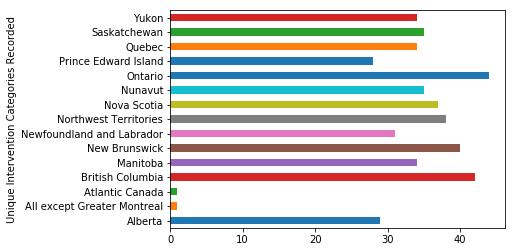

In [73]:
provinces_df.groupby(by='region')['intervention_category'].nunique().plot.barh()
plt.ylabel('Unique Intervention Categories Recorded')

Text(0.5,0,'Number of unique interventions recorded')

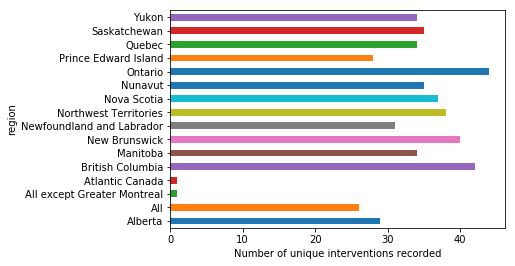

In [74]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['intervention_category'].nunique().plot.barh()
plt.xlabel('Number of unique interventions recorded')


Text(0.5,0,'Number of unique Oxford response measures recorded')

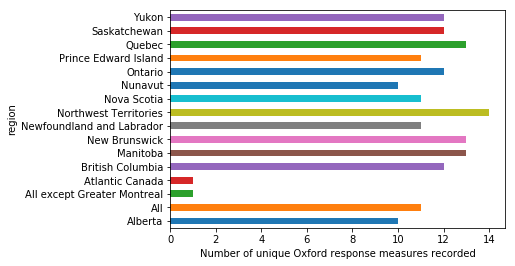

In [75]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_government_response_category'].nunique().plot.barh()
plt.xlabel('Number of unique Oxford response measures recorded')


Text(0.5,0,'Oxford Fiscal Measure (CAD) recorded')

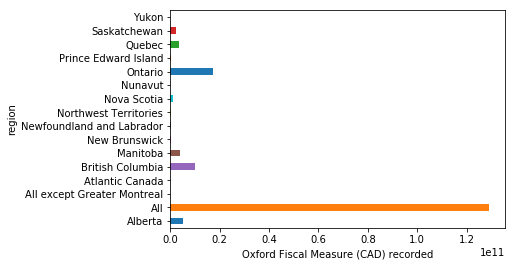

In [76]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_fiscal_measure_cad'].sum().plot.barh()
plt.xlabel('Oxford Fiscal Measure (CAD) recorded')


In [77]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_fiscal_measure_cad'].sum()

region
Alberta                        5.035300e+09
All                            1.290604e+11
All except Greater Montreal    0.000000e+00
Atlantic Canada                1.600000e+07
British Columbia               9.875500e+09
Manitoba                       3.879307e+09
New Brunswick                  1.845016e+08
Newfoundland and Labrador      3.205000e+08
Northwest Territories          1.829650e+08
Nova Scotia                    1.023160e+09
Nunavut                        5.712000e+07
Ontario                        1.745075e+10
Prince Edward Island           1.852250e+08
Quebec                         3.533900e+09
Saskatchewan                   2.496275e+09
Yukon                          2.770000e+07
Name: oxford_fiscal_measure_cad, dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'region' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'$ / person')

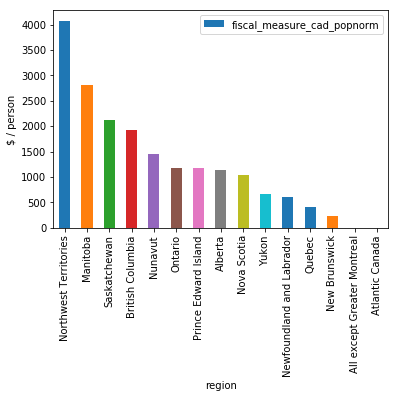

In [78]:
df = pd.DataFrame(provinces_df.groupby(by='region')['oxford_fiscal_measure_cad'].sum())
df['region'] = df.index
df = df.merge(population_df, on='region', how='left')
df['fiscal_measure_cad_popnorm'] = df['oxford_fiscal_measure_cad'] /  df['population_q1_2020']
df = df.sort_values(by='fiscal_measure_cad_popnorm', ascending=False)
df.plot.bar(x='region', y='fiscal_measure_cad_popnorm')
plt.ylabel("$ / person")

Text(0,0.5,'fiscal measures (CAD)')

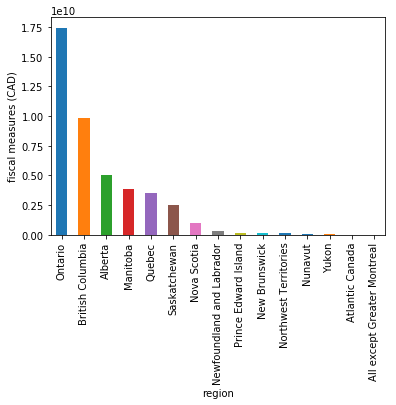

In [79]:
provinces_df.groupby(by='region')['oxford_fiscal_measure_cad'].sum().sort_values(ascending=False).plot.bar()
plt.ylabel('fiscal measures (CAD)')

# Comparing Provincial and Municipal Interventions of the Same Type

In [ ]:
from matplotlib.dates import MO
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 5)

ont_df = full_df[full_df['region'] == 'Ontario']

cmap = mpl.cm.get_cmap('magma')

soc = ont_df[ont_df['intervention_category'] == 'Social Distancing Announcement']
#rec = ont_df[ont_df['intervention_category'] == 'Recreational / Entertainment Facility Closure']
pem = ont_df[ont_df['intervention_category'] == 'Public event/ meeting cancellation or postponement']
#park = ont_df[ont_df['intervention_category'] == 'Public park closure']

start = datetime(2020, 3, 9)
end = datetime(2020, 4, 1) 
drange=(start, end)

pem.groupby('subregion').min()['start_date'].hist(bins=50, range=drange, color=cmap(0.35),  alpha=0.9, cumulative=True, label='Public event cancellation')
#rec.groupby('subregion').min()['start_date'].hist(bins=30, color=cmap(0.8), alpha=0.5, cumulative=True, label='Recreational / Entertainment Facility Closure')
soc.groupby('subregion').min()['start_date'].hist(bins=50, range=drange, color=cmap(0.6), alpha=0.6, cumulative=True, label='Social distancing announcements')
#park.groupby('subregion').min()['start_date'].hist(color='red', alpha=0.5, label='Public park closure')

a = soc[soc['subregion'].isna()]
soc_ont = a[a['intervention_category'] == 'Social Distancing Announcement']
soc_ont_date = soc_ont['start_date'].min()

#a = rec[rec['subregion'].isna()]
rec_ont = a[a['intervention_category'] == 'Recreational / Entertainment Facility Closure']
rec_ont_date = rec_ont['start_date'].min()

plt.axvline(x=rec_ont_date, label='First provincial public event cancellation', color=cmap(0.25), linewidth=2)
plt.axvline(x=soc_ont_date, label='First provincial social distancing announcement', color=cmap(0.65), linewidth=2)

plt.xticks(rotation=45, ha='right')
plt.legend(loc="lower right")
plt.title('Municipality interventions over time in Ontario compared with Provincial interventions')

plt.xlabel('Date')
plt.ylabel('Municipalities with intervention')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO)))
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)


## Heatmap of cumulative municipal top intervention categories

In [ ]:
# Thanks to matplotlib documentation for this

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
top_interventions = full_df.groupby(by='subregion')['intervention_category'].value_counts() \
    .groupby(by='intervention_category') \
    .count() \
    .sort_values(ascending=False)[:10] \
    
top_interventions

In [ ]:
cma_population= pd.DataFrame([['Toronto', 5429524],
                ["Montreal", 3519595],
                ["Vancouver", 2264823],
                ["Calgary", 1237656],
                ["Edmonton", 1062643],
                ["Ottawa", 989657],
                ["Gatineau", 989657],
                ["Winnipeg", 711925],
                ["Quebec City", 705103],
                ["Hamilton", 693645],
                ["Kitchener-Waterloo", 535154],
                ["London", 383437],
                ["Victoria", 335696],
                ["Halifax", 316701],
                ["Oshawa", 308875],
                ["Windsor", 287069],
                ["Saskatoon", 245181],
                ["Niagara", 229246],
                ["Regina", 214631],
                ["St. John's", 178427],
                ["Kelowna", 151957]], columns=['subregion', 'population'])
# Population numbers from Canadian Census 2016

In [ ]:
filtered_df = full_df[full_df['intervention_category'].isin(top_interventions.index.values)]
#filtered_df = filtered_df.groupby(by=['subregion', 'start_date']).nunique()['intervention_category']
filtered_df = filtered_df.merge(cma_population, on='subregion')
filtered_df = filtered_df.sort_values(by='population', ascending=False)
soc_count = filtered_df.groupby(by=['subregion', 'intervention_category'], sort=False).min()['start_date']
#soc_count = soc_count.merge(cma_population, on='subregion')

xticks = pd.date_range(start='03-08-2020', end=cutoff_date, freq='W')


col = ['subregion', *xticks.date]
cma_df = pd.DataFrame()

for subregion in soc_count.index.get_level_values(0).unique():
    dates = soc_count.loc[[subregion]].reset_index()
    empty_row = [subregion]
    for week_end in xticks.values:
        count = dates[dates['start_date'] < week_end]['intervention_category'].count()
        empty_row.append(count)
    cma_df = cma_df.append([empty_row])
    
cma_df.columns = col
cma_df = cma_df.set_index('subregion')

In [ ]:
#fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]}, figsize=(10,6))
fig, ax = plt.subplots(figsize=(10,8))

nice_date = [x.strftime('%B %d') for x in cma_df.columns.values]

im, cbar = heatmap(cma_df.values, cma_df.index.values, nice_date, ax=ax,
                   cmap="magma_r", cbarlabel="# of distinct intervention categories")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
plt.savefig('doc/img/fig5.png', dpi=300)

# Mobility comparison

In [ ]:
ox = full_df['oxford_government_response_category'].unique()

In [ ]:
ox[2]

In [ ]:
gb = provinces_df.groupby(by='region')
for gb_name, g in gb:
    for intervention in ox:
        rows = g[g['oxford_government_response_category'] == intervention]
        if ox[2] in rows['oxford_government_response_category']: # public events
            print(rows['oxford_closure_code'])

In [ ]:
g['oxford_government_response_category'].mode()